In [1]:
%matplotlib inline

import chb
import scipy.io as sio
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

In [2]:
subject = chb.CHBsubj()
subject.load_meta('chb03')
subject.load_data(verbose=True,exthd=False)

Loading: /Users/adamcellon/Drive/senior/thesis/data/chb03.npz
Done: 63.578610 seconds elapsed.


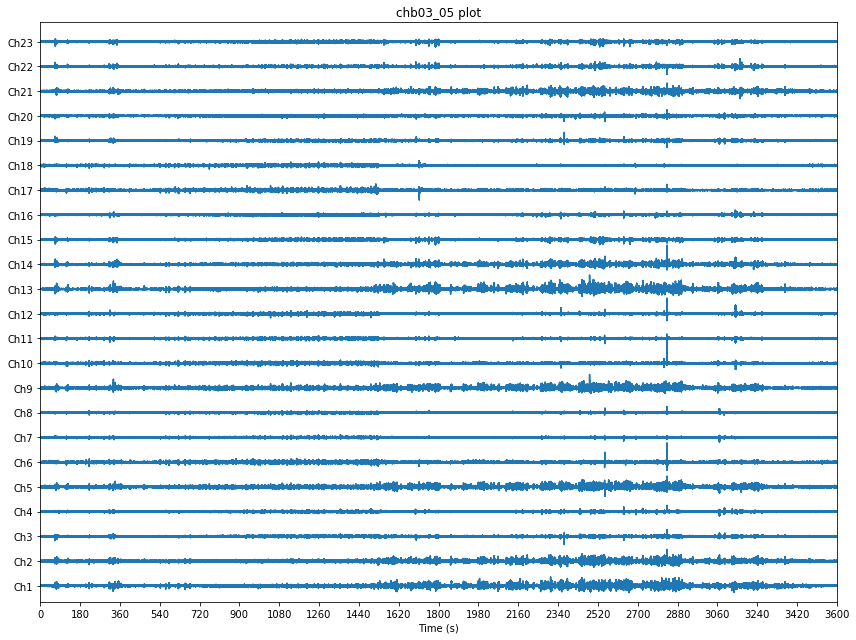

In [3]:
subject[4].plot()

In [ ]:
chb1 = chb.load_meta('chb01')
chb1 = chb.load_data(chb1,exthd=False)

In [ ]:
subj = chbmit.CHBsubj()

In [ ]:
subj.load_meta('chb01')
subj.load_data()

In [ ]:
chb1[2].plot(2000,10000)

In [ ]:
subj.get_file('chb01_03').plot(2000,10000)

## Making epochs

In [ ]:
start = time.clock()
label, epoch = chb.label_epochs(chb1)
stop = time.clock()
print('%f seconds' % (stop-start))